In [47]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import scale
from sklearn.preprocessing import OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import GridSearchCV

# EDA

We'll first load the dataset and do some exploration. 

This resort is our smallest ski resort with the smallest population center nearby, approx 85,000. They report that their limiting factor for daily visitations is their parking lot, which typically tops capacity off at 3,000 visitors and prevents the mountain from becoming too overcrowded. Their lift capacity is 5300 riders per hour. This mountain is a 501(c)3 nonprofit organization, and they generously gave 6 seasons worth of daily visitor data for use in this project. 

It's also worth noting that this moutain is closed on Tuesday and Wednesday unless those days fall during the holidays. 

A couple notes on getting the data for this particular ski area: 

* I was unable to get information about school closures such as winter and spring breaks for this area. 
* Mountain Weather Data was gathered from a nearby SNOTEL station that was not at the ski area (6.9 miles away). This ski area has a private weather station that has only started gathering weather data in the last year. 
* Wind data was not availible for the nearest town
* This ski resort only was open a handful of days during 2018 due to lack of snow and unusually warm weather all winter. 

After cleaning: 

- Dataset count     468.000000

Daily Visitors stats:
- mean      992.083333
- std       586.503671
- min        88.000000
- 25%       557.250000
- 50%       887.500000
- 75%      1329.250000
- max      2944.000000

In [48]:
#Load the dataset, take a look at the data info: 
df_2 = pd.read_csv('Data/Resort_2.csv', thousands=',')
df_2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 644 entries, 0 to 643
Data columns (total 11 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Date              644 non-null    object 
 1   IS_HOLIDAY        644 non-null    int64  
 2   Skier visits day  644 non-null    int64  
 3   SV Nights         557 non-null    float64
 4   TOTAL_VISITS      644 non-null    int64  
 5   M_TEMPAVERAGE_F   644 non-null    int64  
 6   M_PRECIP_INCHES   643 non-null    float64
 7   T_PRCP            644 non-null    float64
 8   T_TMAX            644 non-null    int64  
 9   T_TMIN            644 non-null    int64  
 10  T_TAVG            644 non-null    float64
dtypes: float64(4), int64(6), object(1)
memory usage: 55.5+ KB


In [49]:
#See if there's any duplicates: 
df_2.duplicated().value_counts()

False    582
True      62
dtype: int64

In [50]:
#Drop Duplicates, check to see if we got rid of them:
df_2.drop_duplicates(subset=['Date'], inplace=True)
df_2['Date'].duplicated().value_counts()

False    561
Name: Date, dtype: int64

In [51]:
#Date dealings - make the 'Date' column a datetime object, create day of week and month category to do some EDA and use as variables
#make the 'Date' Column a datetime type
df_2['Date'] = pd.to_datetime(df_2['Date'])

#The day_of_week_num column created with Monday=0, Sunday=6. Weekends = 5 & 6, Friday = 4
df_2['day_of_week_num'] = df_2['Date'].dt.dayofweek

#The month column created
df_2['Month'] = df_2['Date'].dt.month

df_2['day_of_week_num'].value_counts()

5    113
6    112
4    108
3     97
0     97
2     18
1     16
Name: day_of_week_num, dtype: int64

In [52]:
df_2.describe()

,IS_HOLIDAY,Skier visits day,SV Nights,TOTAL_VISITS,M_TEMPAVERAGE_F,M_PRECIP_INCHES,T_PRCP,T_TMAX,T_TMIN,T_TAVG,day_of_week_num,Month
count,561.000000,561.000000,474.000000,561.000000,561.000000,560.000000,561.000000,561.000000,561.000000,561.000000,561.000000,561.000000
mean,0.062389,786.064171,61.061181,837.655971,32.203209,0.238571,0.082852,52.386809,30.814617,41.599822,3.586453,4.495544
std,0.242076,634.459570,179.047829,673.695444,6.974806,0.402601,0.168418,9.027840,6.199182,6.480177,2.039808,4.242270
min,0.000000,0.000000,0.000000,0.000000,14.000000,0.000000,0.000000,32.000000,11.000000,21.500000,0.000000,1.000000
25%,0.000000,305.000000,0.000000,329.000000,27.000000,0.000000,0.000000,46.000000,27.000000,37.000000,3.000000,2.000000
50%,0.000000,683.000000,0.000000,745.000000,32.000000,0.100000,0.000000,51.000000,31.000000,41.000000,4.000000,3.000000
75%,0.000000,1167.000000,0.000000,1239.000000,37.000000,0.300000,0.090000,58.000000,34.000000,46.000000,5.000000,4.000000
max,1.000000,3575.000000,1825.000000,5127.000000,51.000000,2.600000,1.120000,86.000000,51.000000,63.000000,6.000000,12.000000


In [53]:
df_2.isna().sum()

Date                 0
IS_HOLIDAY           0
Skier visits day     0
SV Nights           87
TOTAL_VISITS         0
M_TEMPAVERAGE_F      0
M_PRECIP_INCHES      1
T_PRCP               0
T_TMAX               0
T_TMIN               0
T_TAVG               0
day_of_week_num      0
Month                0
dtype: int64

In [54]:
#Dropping the NAN value in M_PRECIP_INCHES
df_2.dropna(subset=['M_PRECIP_INCHES'], inplace=True)
df_2['M_PRECIP_INCHES'].isna().value_counts()

False    560
Name: M_PRECIP_INCHES, dtype: int64

# Correlation Matrix 
Let's start exploring correlation, taking out `TOTAL_VISITS` (our target), SP, Day and Night related ticket totals to see if any of our variables are highly correlated. Also taking out `Date` as the specific date is not a predictor. 


In [55]:
#removing columns for correlation testing

df_2_corr = df_2.drop(columns=['Date', 'TOTAL_VISITS'])
df_2_corr.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 560 entries, 0 to 643
Data columns (total 11 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   IS_HOLIDAY        560 non-null    int64  
 1   Skier visits day  560 non-null    int64  
 2   SV Nights         474 non-null    float64
 3   M_TEMPAVERAGE_F   560 non-null    int64  
 4   M_PRECIP_INCHES   560 non-null    float64
 5   T_PRCP            560 non-null    float64
 6   T_TMAX            560 non-null    int64  
 7   T_TMIN            560 non-null    int64  
 8   T_TAVG            560 non-null    float64
 9   day_of_week_num   560 non-null    int64  
 10  Month             560 non-null    int64  
dtypes: float64(4), int64(7)
memory usage: 52.5 KB


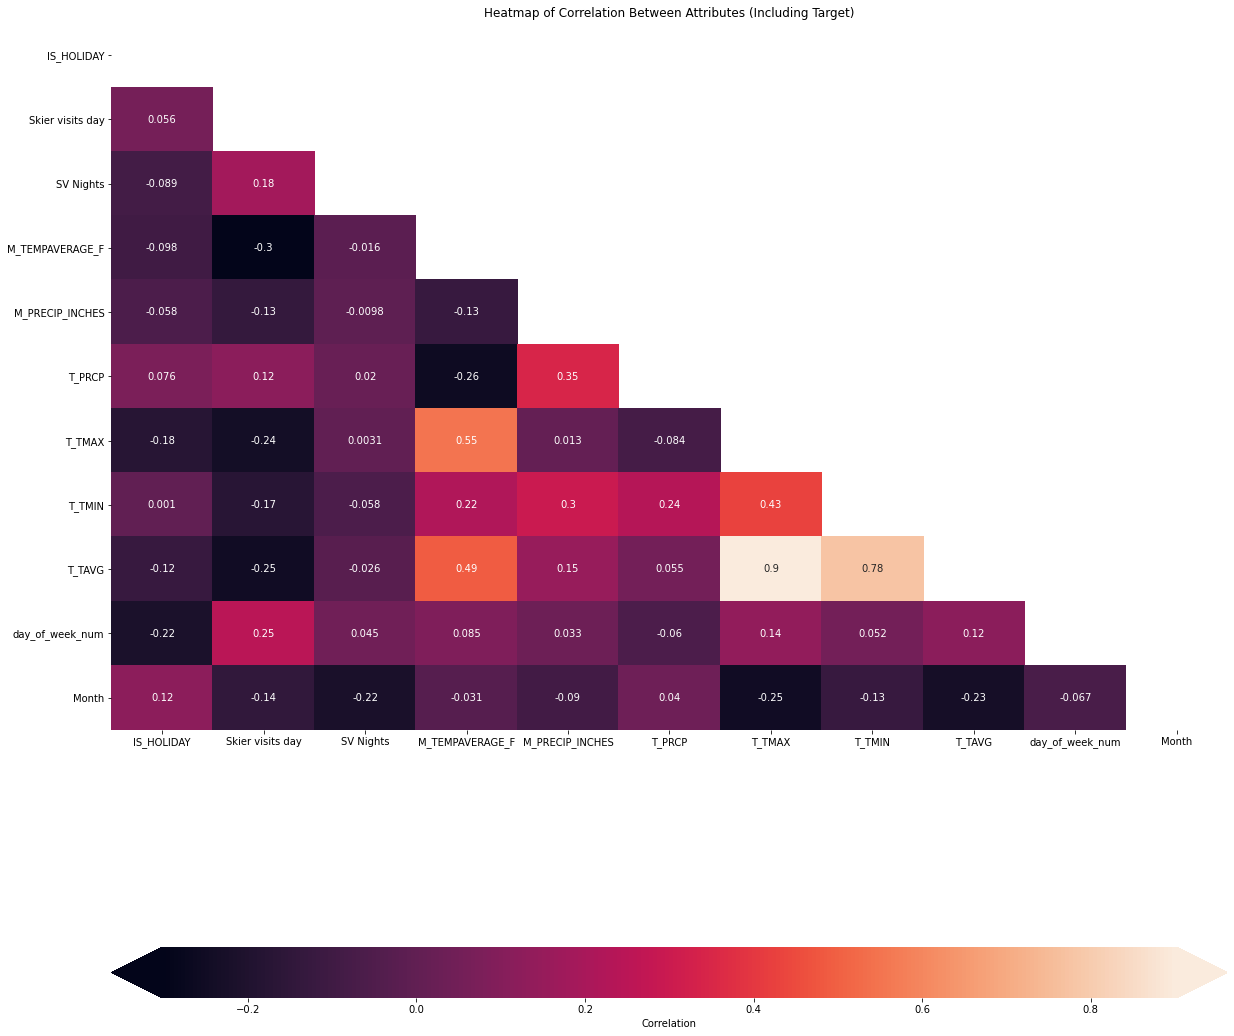

In [56]:
# Create a df with the target as the first column,
# then compute the correlation matrix
heatmap_data = df_2_corr
corr = heatmap_data.corr()

# Set up figure and axes
fig, ax = plt.subplots(figsize=(20, 20))

# Plot a heatmap of the correlation matrix, with both
# numbers and colors indicating the correlations
sns.heatmap(data=corr, mask=np.triu(np.ones_like(corr, dtype=bool)), ax=ax, annot=True, 
            cbar_kws={"label": "Correlation", "orientation": "horizontal", "pad": .2, "extend": "both"})

ax.set_title("Heatmap of Correlation Between Attributes (Including Target)");

In [57]:
#identifying the highest correlated variables

df = df_2_corr.corr().abs().stack().reset_index().sort_values(0, ascending=False)

df['pairs'] = list(zip(df.level_0, df.level_1))

df.set_index(['pairs'], inplace = True)

df.drop(columns=['level_1', 'level_0'], inplace = True)

# cc for correlation coefficient
df.columns = ['cc']

df.drop_duplicates(inplace=True)

df[(df.cc>.75) & (df.cc<1)]


,cc
pairs,
"(T_TMAX, T_TAVG)",0.902177
"(T_TAVG, T_TMIN)",0.778168


### Multicollinairity decision

Based on the information above it makes sense to drop the Town Max Temperature (`T_TMAX`) and the Town Min Temperature (`T_MIN`)

**Ticketing:**

To keep things simple I think for now I am going to remove the ticketing and visit informatoin that breaks down season pass vs ticket and night vs day ticketing. I may want to use these as a prediction if there's time or the business need becomes obvious. Unfortunately I don't have pre-sale data to work with. 

- `SV Nights`
- `Skiier Visits Day`

In [58]:
df_2_preprocessed = df_2.drop(columns=['T_TMAX', 'T_TMIN', 'SV Nights', 'Skier visits day'])
df_2_preprocessed.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 560 entries, 0 to 643
Data columns (total 9 columns):
 #   Column           Non-Null Count  Dtype         
---  ------           --------------  -----         
 0   Date             560 non-null    datetime64[ns]
 1   IS_HOLIDAY       560 non-null    int64         
 2   TOTAL_VISITS     560 non-null    int64         
 3   M_TEMPAVERAGE_F  560 non-null    int64         
 4   M_PRECIP_INCHES  560 non-null    float64       
 5   T_PRCP           560 non-null    float64       
 6   T_TAVG           560 non-null    float64       
 7   day_of_week_num  560 non-null    int64         
 8   Month            560 non-null    int64         
dtypes: datetime64[ns](1), float64(3), int64(5)
memory usage: 43.8 KB


# 0 visit days
Taking a look at rows with 0 visits (these are the days the resort is closed)

In [59]:
df_2_preprocessed[df_2_preprocessed.TOTAL_VISITS == 0]

,Date,IS_HOLIDAY,TOTAL_VISITS,M_TEMPAVERAGE_F,M_PRECIP_INCHES,T_PRCP,T_TAVG,day_of_week_num,Month
26,2016-01-17,0,0,34,1.4,0.42,44.5,6,1
67,2016-03-13,0,0,31,2.3,0.25,43.5,6,3
88,2016-12-01,0,0,25,0.0,0.08,42.0,3,12
89,2016-12-02,0,0,31,0.2,0.00,35.5,4,12
90,2016-12-03,0,0,32,0.0,0.00,35.0,5,12
...,...,...,...,...,...,...,...,...,...
480,2019-12-01,0,0,30,0.5,0.10,32.5,6,12
481,2019-12-02,0,0,35,0.1,0.00,45.0,0,12
482,2019-12-05,0,0,36,0.0,0.00,37.0,3,12
483,2019-12-06,0,0,36,0.3,0.00,44.5,4,12


In [60]:
#dropping the 0 visit days: 
df_2_preprocessed = df_2_preprocessed[df_2_preprocessed.TOTAL_VISITS != 0]
df_2_preprocessed['TOTAL_VISITS'].value_counts()

1026    3
270     3
1548    3
390     3
435     3
       ..
1637    1
1641    1
618     1
1474    1
1505    1
Name: TOTAL_VISITS, Length: 407, dtype: int64

## Indexing with Date/Time

In [61]:
#df_2_preprocessed.reset_index(inplace=True)
df_2_preprocessed.set_index('Date', inplace=True)
df_2_preprocessed.head()


,IS_HOLIDAY,TOTAL_VISITS,M_TEMPAVERAGE_F,M_PRECIP_INCHES,T_PRCP,T_TAVG,day_of_week_num,Month
Date,,,,,,,,
2015-12-14,0,755,24,0.5,1.05,35.0,0,12
2015-12-17,0,735,35,0.1,0.13,34.0,3,12
2015-12-18,0,440,31,0.8,0.10,43.0,4,12
2015-12-19,0,1330,25,0.3,0.77,41.5,5,12
2015-12-22,0,463,31,1.0,0.89,43.0,1,12


## Some Visualizations


Month
1     1171.0
2      980.0
3      656.5
4      508.0
12     922.0
Name: TOTAL_VISITS, dtype: float64


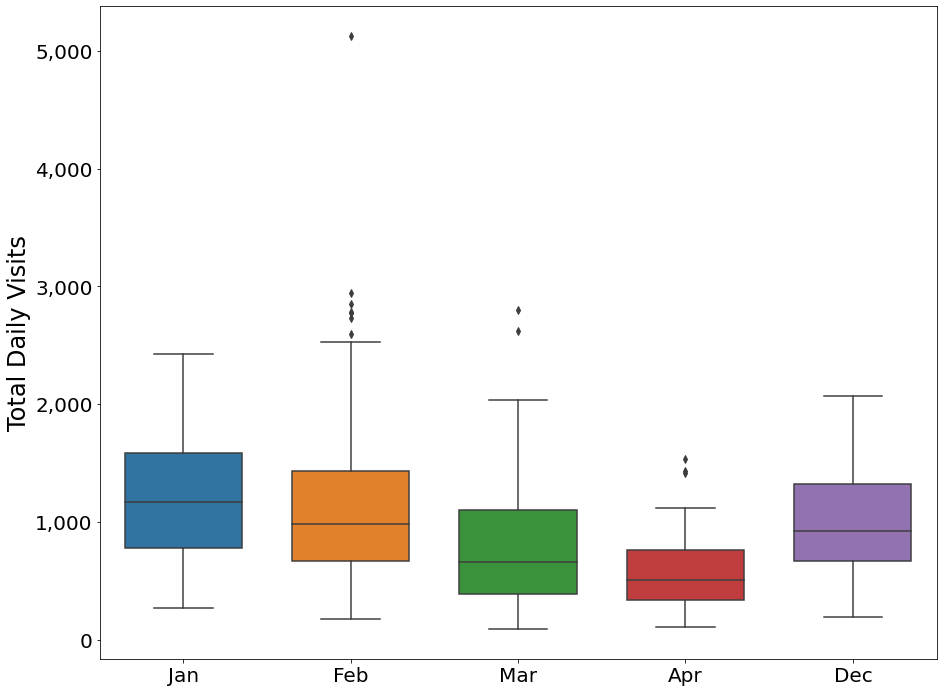

In [62]:
import matplotlib as mpl

fig, ax = plt.subplots(figsize=(15, 12))
sns.boxplot(x='Month', y='TOTAL_VISITS', data=df_2_preprocessed, width=.7)

medians = df_2_preprocessed.groupby(['Month'])['TOTAL_VISITS'].median()
print(medians)

ax.set_xlabel("")

ax.set_ylabel("Total Daily Visits", fontsize=24)

plt.yticks(fontsize=20)

plt.xticks([0, 1, 2, 3, 4], ['Jan', 'Feb', 'Mar', 'Apr', 'Dec'], fontsize=20)

ax.yaxis.set_major_formatter(mpl.ticker.StrMethodFormatter('{x:,.0f}'))


plt.savefig('Visuals/resort2visits.png', dpi=300);

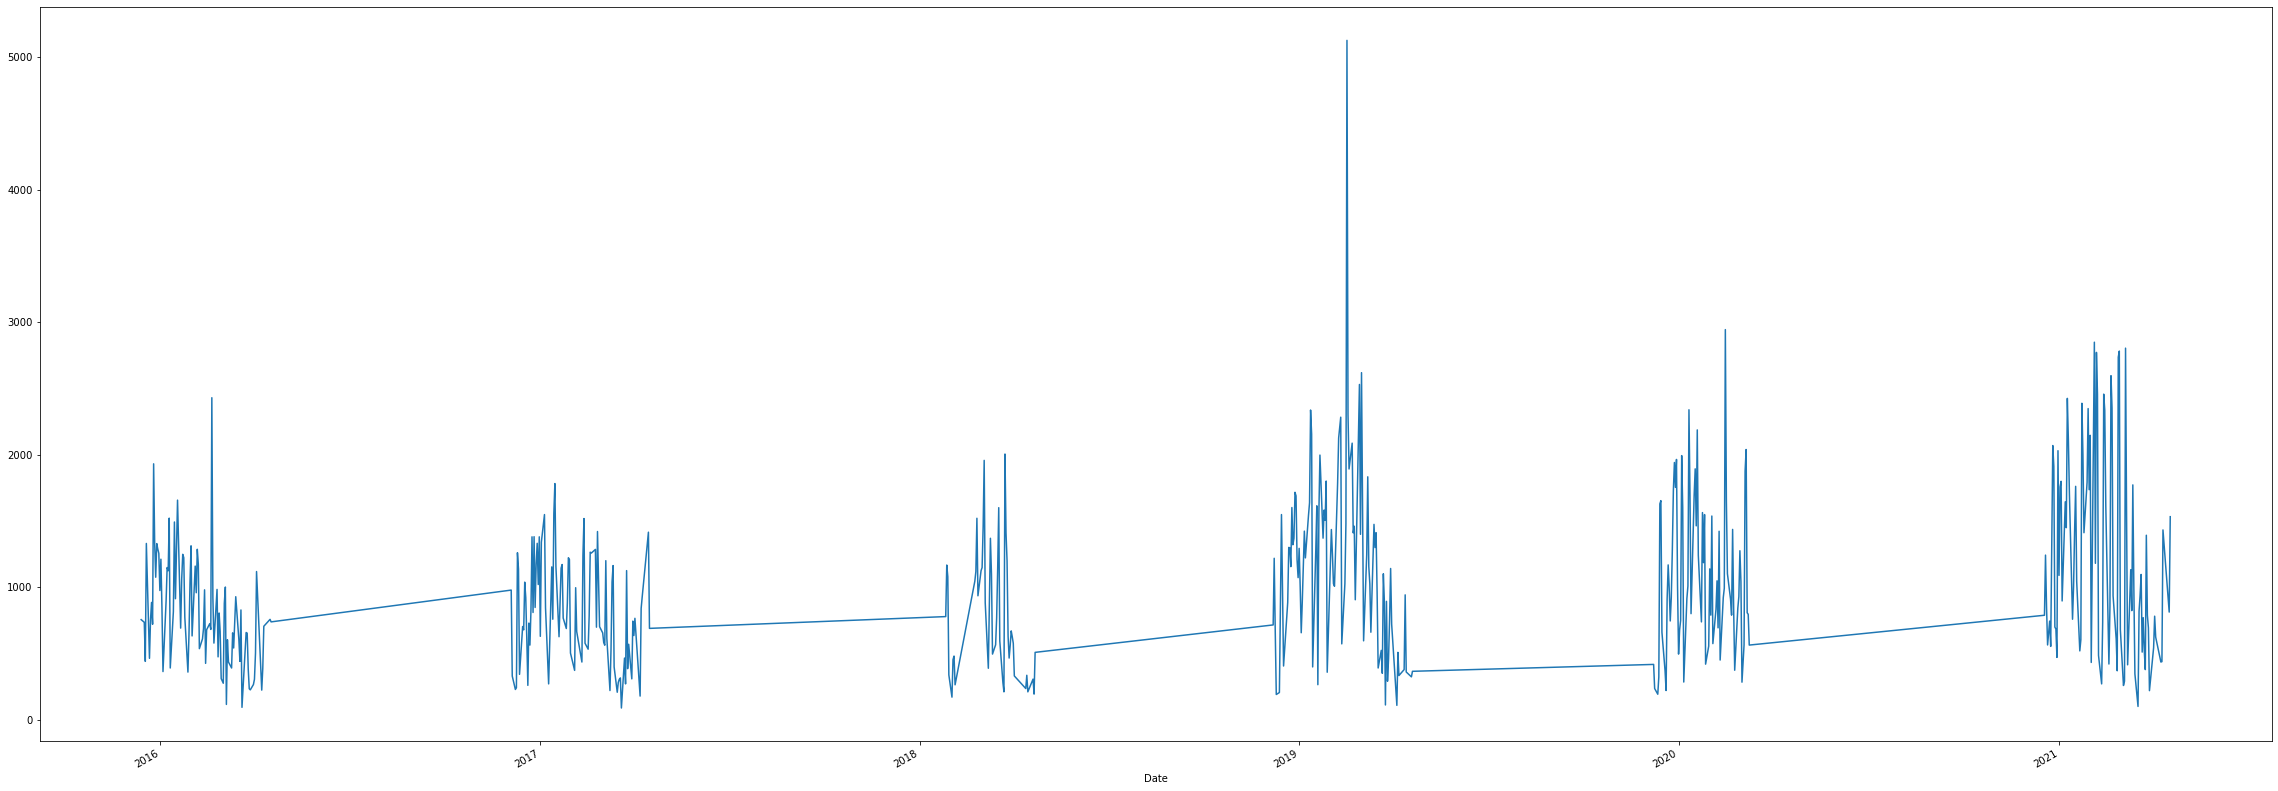

In [63]:
df_2_preprocessed['TOTAL_VISITS'].plot(figsize = (40, 15));

In [64]:
#identified 5,000 + skiier visit day, that is way over capacity for this resort, going to drop that row

df_2_preprocessed = df_2_preprocessed[df_2_preprocessed.TOTAL_VISITS <= 5000]
df_2_preprocessed['TOTAL_VISITS'].describe()

count     468.000000
mean      992.083333
std       586.503671
min        88.000000
25%       557.250000
50%       887.500000
75%      1329.250000
max      2944.000000
Name: TOTAL_VISITS, dtype: float64

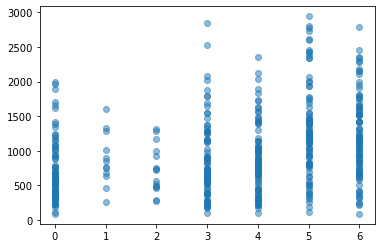

In [65]:
fig, ax = plt.subplots()

ax.scatter(df_2_preprocessed['day_of_week_num'], df_2_preprocessed['TOTAL_VISITS'], alpha=0.5)

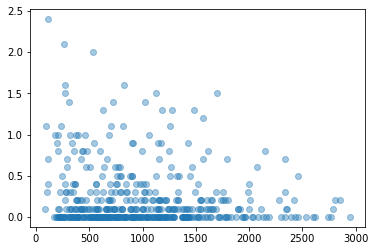

In [66]:
plt.scatter(y=df_2_preprocessed['M_PRECIP_INCHES'], x=df_2_preprocessed['TOTAL_VISITS'], alpha=.4)
plt.savefig('Visuals/resort2precip.png', dpi=300);

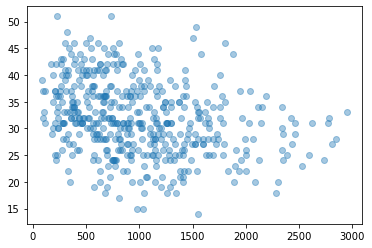

In [67]:
plt.scatter(y=df_2_preprocessed['M_TEMPAVERAGE_F'], x=df_2_preprocessed['TOTAL_VISITS'], alpha=.4)
plt.savefig('Visuals/resort2mountaintemp.png', dpi=300);

IS_HOLIDAY
0     981.613636
1    1156.607143
Name: TOTAL_VISITS, dtype: float64
day_of_week_num
0     713.634146
1     877.416667
2     734.400000
3     877.670886
4     872.489130
5    1283.755319
6    1212.276596
Name: TOTAL_VISITS, dtype: float64


<AxesSubplot:xlabel='M_PRECIP_INCHES', ylabel='TOTAL_VISITS'>

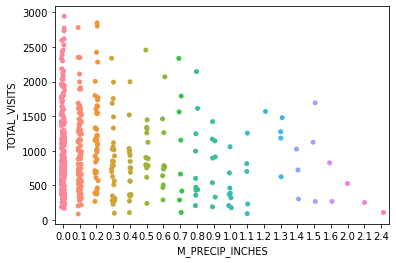

In [68]:
Holiday_averages=df_2_preprocessed.groupby(df_2_preprocessed['IS_HOLIDAY'])['TOTAL_VISITS'].mean()
print(Holiday_averages)

Schoolout_averages=df_2_preprocessed.groupby(df_2_preprocessed['day_of_week_num'])['TOTAL_VISITS'].mean()
print(Schoolout_averages)

fig, ax = plt.subplots()
sns.stripplot(x='M_PRECIP_INCHES', y='TOTAL_VISITS', data=df_2_preprocessed)

/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/seaborn/categorical.py:1296: UserWarning: 12.2% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/seaborn/categorical.py:1296: UserWarning: 5.4% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/seaborn/categorical.py:1296: UserWarning: 7.4% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)


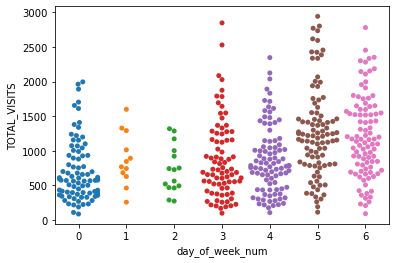

In [69]:
fig, ax = plt.subplots()
sns.swarmplot(x='day_of_week_num', y='TOTAL_VISITS', data=df_2_preprocessed);
plt.savefig('Visuals/resort2dayofweekswarm.png', dpi=300);

# First Simple Model
Linear Regression

In [70]:
#Split into test and train X and Y
X = df_2_preprocessed.drop(columns=['TOTAL_VISITS'])
y = df_2_preprocessed['TOTAL_VISITS']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

In [71]:
y.head()

Date
2015-12-14     755
2015-12-17     735
2015-12-18     440
2015-12-19    1330
2015-12-22     463
Name: TOTAL_VISITS, dtype: int64

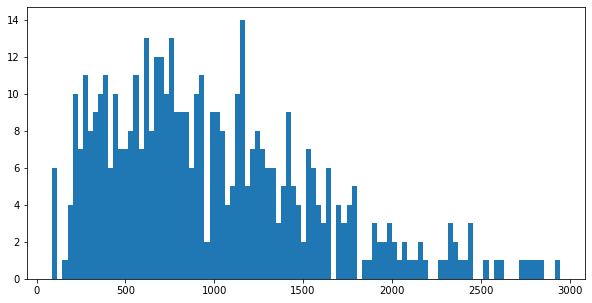

In [72]:
#visualization of target - Visits
fig, ax = plt.subplots(figsize=(10, 5))
ax.hist(y, bins=100);

In [73]:
#Linear Regression
linreg = LinearRegression()
linreg.fit(X_train, y_train)

LinearRegression()

In [74]:
# Print R-Squared and RMSE

from sklearn.metrics import mean_squared_error

# Generate predictions using baseline_model and X_train
y_pred_baseline = linreg.predict(X_train)
print('Training R-Squared:', linreg.score(X_train, y_train))
print('Test R-Squared:', linreg.score(X_test, y_test))
baseline_rmse = mean_squared_error(y_train, y_pred_baseline, squared=False)
baseline_rmse

Training R-Squared: 0.3465711193199502
Test R-Squared: 0.3745636833914624


487.72982743993435

In [75]:
# # Get the cross validated scores for our baseline model
# baseline_cv = cross_val_score(linreg, X_train, y_train, scoring="neg_root_mean_squared_error")

# # Display the average of the cross-validated scores
# baseline_cv_rmse = -(baseline_cv.mean())
# baseline_cv_rmse

# model with OHE and Standard Scaler in a pipeline

In [76]:
#Split into test and train X and Y
X = df_2_preprocessed.drop(columns=['TOTAL_VISITS'])
y = df_2_preprocessed['TOTAL_VISITS']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

#column transformer - this sets up simmilar to pipeline (scaler and transformer)

cat = ['IS_HOLIDAY', 'day_of_week_num', 'Month']
non_cat = ['M_TEMPAVERAGE_F', 'M_PRECIP_INCHES', 'T_PRCP', 'T_TAVG',]

Transformer = ColumnTransformer([
	('ohe', OneHotEncoder(), cat),
	('scaler', StandardScaler(), non_cat),
	], remainder ='passthrough')


LinRegPipe = Pipeline([('trans', Transformer),
                ('linreg', LinearRegression())])

LinRegPipe.fit(X_train, y_train)

X_test.isna().sum()

# Generate predictions using baseline_model and X_train
y_pred_LinRegPipe = LinRegPipe.predict(X_train)
y_pred_linRegPipeTest = LinRegPipe.predict(X_test)
print('Training R-Squared:', LinRegPipe.score(X_train, y_train))
print('Test R-Squared:', LinRegPipe.score(X_test, y_test))
LinRegPipe_rmse = mean_squared_error(y_train, y_pred_baseline, squared=False)
LinRegPipe_rmse

Training R-Squared: 0.42442276292459025
Test R-Squared: 0.38566072485574876


487.72982743993435

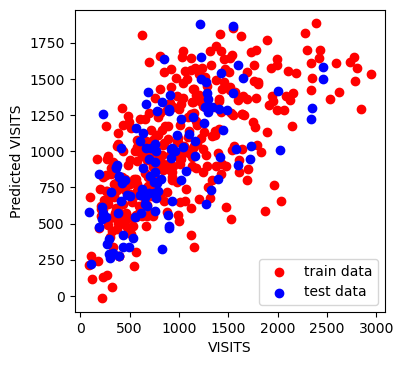

In [77]:
plt.figure(figsize=(4, 4), dpi=100)
plt.xlabel("VISITS")
plt.ylabel("Predicted VISITS")
# plt.xlim(0, 60)
# plt.ylim(0, 60)
plt.scatter(y_train, y_pred_LinRegPipe, lw=1, color="r", label="train data")
plt.scatter(y_test, y_pred_linRegPipeTest, lw=1, color="b", label="test data")
plt.legend()
plt.show()

## Tree Regressor

In [78]:
#Split into test and train X and Y
X = df_2_preprocessed.drop(columns=['TOTAL_VISITS'])
y = df_2_preprocessed['TOTAL_VISITS']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

#column transformer - this sets up simmilar to pipeline (scaler and transformer)

cat = ['IS_HOLIDAY', 'day_of_week_num', 'Month']
non_cat = ['M_TEMPAVERAGE_F', 'M_PRECIP_INCHES', 'T_PRCP', 'T_TAVG',]

Transformer = ColumnTransformer([
	('ohe', OneHotEncoder(), cat),
	# ('scaler', StandardScaler(), non_cat), #no need to scale on Trees
	], remainder ='passthrough')


TreeRegPipe = Pipeline([('trans', Transformer),
                        ('treereg', DecisionTreeRegressor())])

TreeRegPipe.fit(X_train, y_train)

y_pred_tree = TreeRegPipe.predict(X_train)
print('Training R-Squared:', TreeRegPipe.score(X_train, y_train))
print('Test R-Squared:', TreeRegPipe.score(X_test, y_test))
TreeRegPipe_rmse = mean_squared_error(y_train, y_pred_tree, squared=False)
TreeRegPipe_rmse



Training R-Squared: 1.0
Test R-Squared: -0.7272556145556377


0.0

# ##Decision tree is probably overfitting up there, let's do a grid search: 

In [79]:
#pipeline_2:

X = df_2_preprocessed.drop(columns=['TOTAL_VISITS'])
y = df_2_preprocessed['TOTAL_VISITS']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

# Pipeline first step: Transformer

cat = ['IS_HOLIDAY', 'day_of_week_num', 'Month']
non_cat = ['M_TEMPAVERAGE_F', 'M_PRECIP_INCHES', 'T_PRCP', 'T_TAVG',]

Transformer = ColumnTransformer([
	('ohe', OneHotEncoder(), cat),
	# ('scaler', StandardScaler(), non_cat), #no need to scale on Trees
	], remainder ='passthrough')

#Pipeline second Step: treeregressor
dt_clf2 = DecisionTreeRegressor(random_state = 42)

#pipeline
pipeline_2 = Pipeline([('transformer', Transformer),
						('dtr', dt_clf2)])

#set up grid search paramater grid
dt_param_grid = {
    'dtr__min_samples_split': [2, 4, 6, 8],
    'dtr__max_depth': [None, 2, 3, 4, 5, 6]
}

#set up gridsearch:
gridsearch = GridSearchCV(estimator=pipeline_2,
						  param_grid=dt_param_grid,
						  cv=5)


#fit gridsearch
gridsearch.fit(X_train, y_train)

# Print the accuracy on test set
gridsearch.score(X_test, y_test)

gridsearch_opt_tree = gridsearch.predict(X_train)
print('Training R-Squared:', gridsearch.score(X_train, y_train))
print('Test R-Squared:', gridsearch.score(X_test, y_test))
print("Best Parameter Combination Found During Grid Search:")
print(gridsearch.best_params_)
opt_tree_rmse = mean_squared_error(y_train, gridsearch_opt_tree, squared=False)
opt_tree_rmse

Training R-Squared: 0.3681781678395988
Test R-Squared: -0.0371160595913409
Best Parameter Combination Found During Grid Search:
{'dtr__max_depth': 3, 'dtr__min_samples_split': 2}


479.59811485165744

## Wanna try Random Forests? 

In [80]:
#pipeline_3:
from sklearn.ensemble import RandomForestRegressor

X = df_2_preprocessed.drop(columns=['TOTAL_VISITS'])
y = df_2_preprocessed['TOTAL_VISITS']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

# Pipeline first step: Transformer

cat = ['IS_HOLIDAY', 'day_of_week_num', 'Month']
non_cat = ['M_TEMPAVERAGE_F', 'M_PRECIP_INCHES', 'T_PRCP', 'T_TAVG',]

Transformer = ColumnTransformer([
	('ohe', OneHotEncoder(), cat),
	# ('scaler', StandardScaler(), non_cat), #no need to scale on Trees
	], remainder ='passthrough')

#Pipeline second Step: treeregressor
rfr = RandomForestRegressor(random_state = 42)

#pipeline
pipeline_3 = Pipeline([('transformer', Transformer),
						('dtr', rfr)])

#set up grid search paramater grid
rfr_param_grid = {
    'dtr__n_estimators': [2, 4, 6, 8, 10],
    'dtr__max_depth': [None, 2, 3, 4, 5, 6, 8, 10]
}

#set up gridsearch:
gridsearch2 = GridSearchCV(estimator=pipeline_3,
						  param_grid=rfr_param_grid,
						  cv=5)


#fit gridsearch
gridsearch2.fit(X_train, y_train)

# Print the accuracy on test set
gridsearch2.score(X_test, y_test)

gridsearch2_opt_forest = gridsearch2.predict(X_train)
print('Training R-Squared:', gridsearch2.score(X_train, y_train))
print('Test R-Squared:', gridsearch2.score(X_test, y_test))
print("Best Parameter Combination Found During Grid Search:")
print(gridsearch2.best_params_)
opt_tree_rmse = mean_squared_error(y_train, gridsearch2_opt_forest, squared=False)
opt_tree_rmse

Training R-Squared: 0.6894057804309277
Test R-Squared: 0.28902326358559216
Best Parameter Combination Found During Grid Search:
{'dtr__max_depth': 6, 'dtr__n_estimators': 10}


336.2612611791891

For this dataset, forests are performing better than trees

In [81]:
y_pred = gridsearch2.predict(X_test)

df = pd.DataFrame({'Real Values':y_test, 'Predicted Values':y_pred})
df

,Real Values,Predicted Values
Date,,
2016-02-28,665,916.236401
2016-03-10,390,493.567302
2016-01-29,641,1347.303039
2019-03-27,290,723.347248
2016-03-24,658,614.529276
...,...,...
2016-04-16,757,752.324474
2019-12-24,745,1028.636086
2018-12-31,1072,983.331496


Gradient Boosting: 

In [82]:
from sklearn.ensemble import GradientBoostingRegressor

#pipeline_4:

X = df_2_preprocessed.drop(columns=['TOTAL_VISITS'])
y = df_2_preprocessed['TOTAL_VISITS']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

# Pipeline first step: Transformer

cat = ['IS_HOLIDAY', 'day_of_week_num', 'Month']
non_cat = ['M_TEMPAVERAGE_F', 'M_PRECIP_INCHES', 'T_PRCP', 'T_TAVG',]

Transformer = ColumnTransformer([
	('ohe', OneHotEncoder(), cat),
	# ('scaler', StandardScaler(), non_cat), #no need to scale on Trees
	], remainder ='passthrough')

#Pipeline second Step: treeregressor
GBR = GradientBoostingRegressor(random_state = 42)

#pipeline
pipeline_4 = Pipeline([('transformer', Transformer),
						('gbr', GBR)])

#set up grid search paramater grid
gbr_param_grid = {
    'gbr__n_estimators': [50, 100, 200, 300],
    'gbr__criterion': ['friedman_mse', 'mse', 'mae']
}

#set up gridsearch:
gridsearch3 = GridSearchCV(estimator=pipeline_4,
						  param_grid=gbr_param_grid,
						  cv=5)


#fit gridsearch
gridsearch3.fit(X_train, y_train)

# Print the accuracy on test set
gridsearch3.score(X_test, y_test)

gridsearch3_opt = gridsearch3.predict(X_train)
print('Training R-Squared:', gridsearch3.score(X_train, y_train))
print('Test R-Squared:', gridsearch3.score(X_test, y_test))
print("Best Parameter Combination Found During Grid Search:")
print(gridsearch3.best_params_)
opt_gbr_rmse = mean_squared_error(y_train, gridsearch3_opt, squared=False)
opt_gbr_rmse


Training R-Squared: 0.7410915939424328
Test R-Squared: 0.2611300775967492
Best Parameter Combination Found During Grid Search:
{'gbr__criterion': 'mse', 'gbr__n_estimators': 100}


307.0104997490633

In [83]:
from sklearn.ensemble import GradientBoostingRegressor

#pipeline_booster:

X_boost = df_2_preprocessed.drop(columns=['TOTAL_VISITS'])
y_boost = df_2_preprocessed['TOTAL_VISITS']
X_train_boost, X_test_boost, y_train_boost, y_test_boost = train_test_split(X_boost, y_boost, test_size=0.25, random_state=42)

# Pipeline first step: Transformer

cat = ['IS_HOLIDAY', 'day_of_week_num', 'Month']
non_cat = ['M_TEMPAVERAGE_F', 'M_PRECIP_INCHES', 'T_PRCP', 'T_TAVG',]

Transformer = ColumnTransformer([
	('ohe', OneHotEncoder(), cat),
	# ('scaler', StandardScaler(), non_cat), #no need to scale on Trees
	], remainder ='passthrough')

#Pipeline second Step: treeregressor
GBR = GradientBoostingRegressor(criterion= 'friedman_mse', n_estimators=100, random_state = 42)

#pipeline
pipeline_boost = Pipeline([('transformer', Transformer),
						('gbr', GBR)])

pipeline_boost.fit(X_train_boost, y_train_boost)

# Print the accuracy on test set
print(pipeline_boost.score(X_test_boost, y_test_boost))

boost_pred = pipeline_boost.predict(X_train_boost)
print('Training R-Squared:', pipeline_boost.score(X_train_boost, y_train_boost))
print('Test R-Squared:', pipeline_boost.score(X_test_boost, y_test_boost))

boost_rmse = mean_squared_error(y_train_boost, gridsearch3_opt, squared=False)
boost_rmse

0.2611604753141612
Training R-Squared: 0.7410915939424328
Test R-Squared: 0.2611604753141612


307.0104997490633

In [84]:
y_pred_boost = pipeline_boost.predict(X_test_boost)

df = pd.DataFrame({'Real Visits':y_test_boost, 'Predicted Visits':y_pred_boost, 'Difference': abs(y_test_boost - y_pred_boost)})
df

,Real Visits,Predicted Visits,Difference
Date,,,
2016-02-28,665,1153.496272,488.496272
2016-03-10,390,257.571756,132.428244
2016-01-29,641,1703.931372,1062.931372
2019-03-27,290,419.610431,129.610431
2016-03-24,658,511.945349,146.054651
...,...,...,...
2016-04-16,757,731.005617,25.994383
2019-12-24,745,863.657424,118.657424
2018-12-31,1072,1095.863240,23.863240


In [85]:
import xgboost as xg

from sklearn.ensemble import GradientBoostingRegressor

#pipeline_4:

X = df_2_preprocessed.drop(columns=['TOTAL_VISITS'])
y = df_2_preprocessed['TOTAL_VISITS']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

# Pipeline first step: Transformer

cat = ['IS_HOLIDAY', 'day_of_week_num', 'Month']
non_cat = ['M_TEMPAVERAGE_F', 'M_PRECIP_INCHES', 'T_PRCP', 'T_TAVG',]

Transformer = ColumnTransformer([
	('ohe', OneHotEncoder(), cat),
	# ('scaler', StandardScaler(), non_cat), #no need to scale on Trees
	], remainder ='passthrough')

#Pipeline second Step: treeregressor
xgb_r = xg.XGBRegressor(objective ='reg:squarederror', n_estimators = 10, seed = 123)

#pipeline
xboostPipe = Pipeline([('transformer', Transformer),
						('xgb_r', xgb_r)])

# #set up grid search paramater grid
# gbr_param_grid = {
#     'gbr__n_estimators': [50, 100, 200, 300],
#     'gbr__criterion': ['friedman_mse', 'mse', 'mae']
# }

# #set up gridsearch:
# gridsearch3 = GridSearchCV(estimator=pipeline_4,
# 						  param_grid=gbr_param_grid,
# 						  cv=5)


#fit gridsearch
xboostPipe.fit(X_train, y_train)

# Print the accuracy on test set
xboostPipe.score(X_test, y_test)

xboost_pred = xboostPipe.predict(X_train)
print('Training R-Squared:', xboostPipe.score(X_train, y_train))
print('Test R-Squared:', xboostPipe.score(X_test, y_test))
# print("Best Parameter Combination Found During Grid Search:")
# print(gridsearch3.best_params_)
xboost_rmse = mean_squared_error(y_train, xboost_pred, squared=False)
xboost_rmse


Training R-Squared: 0.8188402586230341
Test R-Squared: 0.24613644885677743


256.8094490209982

In [86]:
y_pred = gridsearch2.predict(X_test)

df = pd.DataFrame({'Real Values':y_test, 'Predicted Values':y_pred, 'Difference': abs(y_test - y_pred)})
df

,Real Values,Predicted Values,Difference
Date,,,
2016-02-28,665,916.236401,251.236401
2016-03-10,390,493.567302,103.567302
2016-01-29,641,1347.303039,706.303039
2019-03-27,290,723.347248,433.347248
2016-03-24,658,614.529276,43.470724
...,...,...,...
2016-04-16,757,752.324474,4.675526
2019-12-24,745,1028.636086,283.636086
2018-12-31,1072,983.331496,88.668504
